# 0.0 Imports

In [113]:
import numpy   as np
import pandas  as pd
import seaborn as sns
import umap.umap_ as umap
import regex as re
import warnings

from IPython.display     import HTML
from matplotlib          import pyplot  as plt
from sklearn             import cluster as c
from sklearn             import metrics as m
from plotly              import express as px
from sklearn             import preprocessing as pp
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## 0.1. Helper functions

In [114]:
def jupyter_settings():
    %matplotlib inline
    
    display( HTML('<style>.container { width:100% !important; }</style>'))
    pd.set_option('display.expand_frame_repr', False)
    warnings.filterwarnings("ignore")    
    
    sns.set()
    
jupyter_settings()

## 0.2. Load dataset

In [115]:
# load data
df_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding='unicode_escape')

df_raw

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Unnamed: 8
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,7-Dec-17,0.85,12680.0,France,NaN
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,7-Dec-17,2.10,12680.0,France,NaN
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,7-Dec-17,4.15,12680.0,France,NaN
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,7-Dec-17,4.15,12680.0,France,NaN


In [116]:
# drop extra column
df_raw = df_raw.drop(columns=['Unnamed: 8'], axis=1)

# 1.0 Data description

In [117]:
df1 = df_raw.copy()

## 1.1 Rename columuns

In [118]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2 Data types

In [119]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.3 Check NA

In [120]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.4 Replace NA

In [121]:
df_missing = df1.loc[df1['customer_id'].isna()]
df_not_missing = df1.loc[~df1['customer_id'].isna()]

# create reference
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup), 1)

# merge original with reference dataframe
df1 = pd.merge(df1, df_backup, on='invoice_no', how='left')

# coalesce 
df1['customer_id'] = df1['customer_id_x'].combine_first( df1['customer_id_y'])

# drop extra columns
df1 = df1.drop(columns=['customer_id_x', 'customer_id_y'], axis=1)

In [122]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.5 Change dtypes

In [123]:
# invoice date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer id
df1['customer_id'] = df1['customer_id'].astype(int)
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


In [124]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 1.6 Descriptive statistics

In [125]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.6.1 Numerical attributes

In [126]:
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
             
# dispersion - desvio padrão, minimo, maximo, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
metrics = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
metrics.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
metrics

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


#### 1.6.1.1 Quantity

In [127]:
print(len(df1[df1['quantity']==0]))
print(len(df1[df1['quantity']<0]))
print(len(df1[df1['quantity']>0]))

0
10624
531285


#### 1.6.1.2 Unit price

In [128]:
df1[(df1['unit_price']>0.00) & (df1['unit_price']<=0.03)]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
4287,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,2016-11-30,0.030,United Kingdom,15838
108088,C545478,D,Discount,-720,2017-03-01,0.010,United Kingdom,16422
157195,550193,PADS,PADS TO MATCH ALL CUSHIONS,1,2017-04-13,0.001,United Kingdom,13952
182729,C552569,D,Discount,-240,2017-05-08,0.030,United Kingdom,12901
279045,561226,PADS,PADS TO MATCH ALL CUSHIONS,1,2017-07-24,0.001,United Kingdom,15618
355050,C567903,M,Manual,-120,2017-09-20,0.030,United Kingdom,16422
359871,568200,PADS,PADS TO MATCH ALL CUSHIONS,1,2017-09-23,0.001,United Kingdom,16198
361741,568375,BANK CHARGES,Bank Charges,1,2017-09-24,0.001,United Kingdom,13405


In [129]:
df1[(df1['unit_price']>0.00) & (df1['unit_price']<=0.04)]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
4287,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,2016-11-30,0.030,United Kingdom,15838
108088,C545478,D,Discount,-720,2017-03-01,0.010,United Kingdom,16422
157195,550193,PADS,PADS TO MATCH ALL CUSHIONS,1,2017-04-13,0.001,United Kingdom,13952
182729,C552569,D,Discount,-240,2017-05-08,0.030,United Kingdom,12901
217060,555876,16045,POPART WOODEN PENCILS ASST,100,2017-06-05,0.040,United Kingdom,15799
...,...,...,...,...,...,...,...,...
492556,578126,16045,POPART WOODEN PENCILS ASST,100,2017-11-21,0.040,United Kingdom,16900
506043,579124,16045,POPART WOODEN PENCILS ASST,100,2017-11-26,0.040,United Kingdom,15721
506918,579161,16045,POPART WOODEN PENCILS ASST,100,2017-11-26,0.040,United Kingdom,17379
523461,580513,16045,POPART WOODEN PENCILS ASST,100,2017-12-02,0.040,United Kingdom,14456


In [130]:
len(df1[df1['unit_price']<0.05])

2591

#### 1.6.1.3 Customer id

In [131]:
len(df1['customer_id'].unique())

8082

questions :

Negativate quantity - product return?

Unit price 0 - promotion/sale?

### 1.6.2 Categorical attributes

#### 1.6.2.1 Invoice no

In [132]:
df_letter_invoices = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search( '[^0-9]+', x))),:]
# df_letter_invoices.head()

print('Total number of invoices with letters: {}'.format( len(df_letter_invoices)))
print('Total number of negative quantity in invoices with letters: {}'.format(len(df_letter_invoices[df_letter_invoices['quantity'] < 0])))
print('% of the total data: {:.2f}%'.format((df_letter_invoices.shape[0] / df1.shape[0])*100))

Total number of invoices with letters: 9291
Total number of negative quantity in invoices with letters: 9288
% of the total data: 1.71%


In [133]:
df_letter_invoices[df_letter_invoices['quantity'] > 0]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
299982,A563185,B,Adjust bad debt,1,2017-08-10,11062.06,United Kingdom,21497
299983,A563186,B,Adjust bad debt,1,2017-08-10,-11062.06,United Kingdom,21498
299984,A563187,B,Adjust bad debt,1,2017-08-10,-11062.06,United Kingdom,21499


remove customers 21497,21498,21499

#### 1.6.2.2 Stock code

In [134]:
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search( '^[a-zA-Z]+$', x))), 'stock_code'].unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

In [135]:
df_stock_letters=df1.loc[df1['stock_code'].apply(lambda x: bool(re.search( '^[a-zA-Z]+$', x))), 'stock_code']
print('% of the total data: {:.2f}%'.format((df_stock_letters.shape[0] / df1.shape[0])*100))

% of the total data: 0.51%


In [136]:
df1[df1['stock_code']=='POST'].head()

# not remove

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
45,536370,POST,POSTAGE,3,2016-11-29,18.0,France,12583
386,536403,POST,POSTAGE,1,2016-11-29,15.0,Netherlands,12791
1123,536527,POST,POSTAGE,1,2016-11-29,18.0,Germany,12662
5073,536840,POST,POSTAGE,1,2016-11-30,18.0,Germany,12738
5258,536852,POST,POSTAGE,1,2016-12-01,18.0,France,12686


In [137]:
df1[df1['stock_code']=='D']

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
141,C536379,D,Discount,-1,2016-11-29,27.50,United Kingdom,14527
9038,C537164,D,Discount,-1,2016-12-03,29.29,United Kingdom,14527
14498,C537597,D,Discount,-1,2016-12-05,281.00,United Kingdom,15498
19392,C537857,D,Discount,-1,2016-12-06,267.12,United Kingdom,17340
31134,C538897,D,Discount,-1,2016-12-13,5.76,United Kingdom,16422
...,...,...,...,...,...,...,...,...
479868,C577227,D,Discount,-1,2017-11-16,19.82,United Kingdom,14527
479869,C577227,D,Discount,-1,2017-11-16,16.76,United Kingdom,14527
493613,C578239,D,Discount,-1,2017-11-21,26.33,Italy,14912
516221,C579884,D,Discount,-1,2017-11-28,20.53,United Kingdom,14527


In [138]:
df1[(df1['stock_code']=='D') & (df1['quantity']>0)]

# will be removed with invoice letters

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id


In [139]:
df1[df1['stock_code']=='DOT']

# not remove

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
1814,536544,DOT,DOTCOM POSTAGE,1,2016-11-29,569.77,United Kingdom,19001
3041,536592,DOT,DOTCOM POSTAGE,1,2016-11-29,607.49,United Kingdom,19014
5450,536862,DOT,DOTCOM POSTAGE,1,2016-12-01,254.43,United Kingdom,19023
5545,536864,DOT,DOTCOM POSTAGE,1,2016-12-01,121.06,United Kingdom,19024
5685,536865,DOT,DOTCOM POSTAGE,1,2016-12-01,498.47,United Kingdom,19025
...,...,...,...,...,...,...,...,...
536834,581219,DOT,DOTCOM POSTAGE,1,2017-12-06,1008.96,United Kingdom,22696
537254,581238,DOT,DOTCOM POSTAGE,1,2017-12-06,1683.75,United Kingdom,22699
539368,581439,DOT,DOTCOM POSTAGE,1,2017-12-06,938.59,United Kingdom,22706
540908,581492,DOT,DOTCOM POSTAGE,1,2017-12-07,933.17,United Kingdom,22707


In [140]:
df1[df1['stock_code']=='M']

# not remove

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
2239,536569,M,Manual,1,2016-11-29,1.25,United Kingdom,16274
2250,536569,M,Manual,1,2016-11-29,18.95,United Kingdom,16274
5684,536865,M,Manual,1,2016-12-01,2.55,United Kingdom,19025
6798,536981,M,Manual,2,2016-12-01,0.85,United Kingdom,14723
7976,537077,M,Manual,12,2016-12-03,0.42,United Kingdom,17062
...,...,...,...,...,...,...,...,...
531432,580956,M,Manual,4,2017-12-04,1.25,United Kingdom,17841
533082,C581009,M,Manual,-1,2017-12-05,125.00,United Kingdom,16971
534308,C581145,M,Manual,-1,2017-12-05,9.95,United Kingdom,17490
538321,581405,M,Manual,3,2017-12-06,0.42,United Kingdom,13521


In [141]:
df1[df1['stock_code']=='S']

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
14436,C537581,S,SAMPLES,-1,2016-12-05,12.95,United Kingdom,19100
14437,C537581,S,SAMPLES,-1,2016-12-05,52.00,United Kingdom,19100
96680,C544580,S,SAMPLES,-1,2017-02-19,5.74,United Kingdom,19707
96681,C544580,S,SAMPLES,-1,2017-02-19,11.08,United Kingdom,19707
96682,C544580,S,SAMPLES,-1,2017-02-19,5.79,United Kingdom,19707
...,...,...,...,...,...,...,...,...
414147,C572347,S,SAMPLES,-1,2017-10-22,33.05,United Kingdom,22090
419666,572849,S,SAMPLES,1,2017-10-24,33.05,United Kingdom,22159
480961,C577330,S,SAMPLES,-1,2017-11-16,2.89,United Kingdom,22469
480962,C577330,S,SAMPLES,-1,2017-11-16,75.00,United Kingdom,22469


In [142]:
df1[(df1['stock_code']=='S') & (df1['quantity']>0)]

# not remove

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
152709,549684,S,SAMPLES,1,2017-04-09,30.00,United Kingdom,20307
419666,572849,S,SAMPLES,1,2017-10-24,33.05,United Kingdom,22159


In [143]:
df1[df1['stock_code']=='AMAZONFEE'].head()

# remove

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
14514,C537600,AMAZONFEE,AMAZON FEE,-1,2016-12-05,1.00,United Kingdom,19101
15016,C537630,AMAZONFEE,AMAZON FEE,-1,2016-12-05,13541.33,United Kingdom,19105
15017,537632,AMAZONFEE,AMAZON FEE,1,2016-12-05,13541.33,United Kingdom,19106
16232,C537644,AMAZONFEE,AMAZON FEE,-1,2016-12-05,13474.79,United Kingdom,19116
16313,C537647,AMAZONFEE,AMAZON FEE,-1,2016-12-05,5519.25,United Kingdom,19117


In [144]:
df1[df1['stock_code']=='m']

# not remove

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
40383,539736,m,Manual,1,2016-12-19,2.55,United Kingdom,19282


In [145]:
df1[df1['stock_code']=='DCGSSBOY'].head()

# not remove

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
84016,543358,DCGSSBOY,BOYS PARTY BAG,1,2017-02-05,3.29,United Kingdom,19614
97246,544599,DCGSSBOY,BOYS PARTY BAG,1,2017-02-19,3.29,United Kingdom,19715
112723,545897,DCGSSBOY,BOYS PARTY BAG,5,2017-03-05,3.29,United Kingdom,19801
116891,546306,DCGSSBOY,BOYS PARTY BAG,1,2017-03-08,3.29,United Kingdom,19843
128107,547249,DCGSSBOY,BOYS PARTY BAG,6,2017-03-20,3.29,United Kingdom,19916


In [146]:
df1[df1['stock_code']=='DCGSSGIRL'].head()

# not remove

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
84017,543358,DCGSSGIRL,GIRLS PARTY BAG,3,2017-02-05,3.29,United Kingdom,19614
112724,545897,DCGSSGIRL,GIRLS PARTY BAG,5,2017-03-05,3.29,United Kingdom,19801
116892,546306,DCGSSGIRL,GIRLS PARTY BAG,2,2017-03-08,3.29,United Kingdom,19843
128108,547249,DCGSSGIRL,GIRLS PARTY BAG,17,2017-03-20,3.29,United Kingdom,19916
128269,547250,DCGSSGIRL,GIRLS PARTY BAG,2,2017-03-20,3.29,United Kingdom,19917


In [147]:
# df1[df1['stock_code']=='PADS'].head()

# removed with low price

In [148]:
df1[df1['stock_code']=='B']

# remove

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
299982,A563185,B,Adjust bad debt,1,2017-08-10,11062.06,United Kingdom,21497
299983,A563186,B,Adjust bad debt,1,2017-08-10,-11062.06,United Kingdom,21498
299984,A563187,B,Adjust bad debt,1,2017-08-10,-11062.06,United Kingdom,21499


In [149]:
# df1[df1['stock_code']=='CRUK'].head()

# will be removed with invoice letters

TO REMOVE: 'AMAZONFEE', 'B'

#### 1.6.2.3 Description

In [150]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


#### 1.6.2.4 Country

In [151]:
df1['country'].value_counts( normalize=True ).head()

country
United Kingdom    0.914320
Germany           0.017521
France            0.015790
EIRE              0.015124
Spain             0.004674
Name: proportion, dtype: float64

In [152]:
df1[['customer_id', 'country']].drop_duplicates().groupby( 'country' ).count().reset_index().sort_values( 'customer_id', ascending=False)

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31
3,Belgium,25
33,Switzerland,24
27,Portugal,20
19,Italy,15
16,Hong Kong,15


# 2.0 Variable filtering 

In [153]:
df2 = df1.copy()

In [154]:
# unit price
df2 = df2.loc[df2['unit_price'] >= 0.04]

# stock code
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'] ) ]

# description
df2 = df2.drop(columns='description', axis=1)

# bad customers
df1=df1[~df1['customer_id'].isin([21497,21498,21499])]

# country
df2 = df2[~df2['country'].isin( ['European Community', 'Unspecified' ] ) ]

# quantity
df2_returns = df2.loc[df1['quantity'] < 0]

# purchases
df2_purchases = df2.loc[df1['quantity'] >= 0]

print('% of the data lost : {:.3f}%'.format(1-(df2.shape[0] / df1.shape[0])))

% of the data lost : 0.005%


# 3.0 Feature engineering 

In [155]:
df3 = df2.copy()

## 3.1 Feature creation

In [156]:
# data reference
df_ref = df3.drop(['invoice_no', 'stock_code', 
                    'quantity', 'invoice_date', 'unit_price', 
                    'country'], axis=1 ).drop_duplicates(ignore_index=True)


# Gross Revenue - quantity * price
df3['gross_revenue'] = df3['quantity'] * df3['unit_price']
# Monetary
df_monetary = df3[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')


# Recency - Last day of purchase
df_recency = df3[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df3['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')


# # Frequency
df_freq = df3[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')


# Avg Ticket
df_avg_ticket = df3[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')


df_ref=df_ref.rename(columns={'invoice_no':'total_invoices'})

# <font color='red'> 4.0 EDA (Exploratory Data Analysis) </font>

In [100]:
df4 = df_ref.copy()

In [101]:
# profile = ProfileReport(df4)
# profile.to_file('../img/output_v1.html')

## 4.1 Univariate analysis

### 4.1.1 Gross revenue

In [102]:
df4.sort_values('gross_revenue', ascending=False).head()

,customer_id,gross_revenue,recency_days,total_invoices,avg_ticket
1024,14646,279489.02,1,76,134.305151
497,18102,256438.49,0,62,592.236697
433,17450,187482.17,8,55,534.137236
67,14911,132572.62,1,248,22.466128
1159,12415,123725.45,24,26,159.440013


In [103]:
df4[df4['customer_id'] == 14646]

,customer_id,gross_revenue,recency_days,total_invoices,avg_ticket
1024,14646,279489.02,1,76,134.305151


In [104]:
df4[df4['customer_id'] == 18102].head()

,customer_id,gross_revenue,recency_days,total_invoices,avg_ticket
497,18102,256438.49,0,62,592.236697


### 4.1.2 Avg ticket

In [105]:
df4.sort_values('avg_ticket', ascending=False).head()

,customer_id,gross_revenue,recency_days,total_invoices,avg_ticket
4133,21245,4287.63,144,1,4287.63
5926,15195,3861.00,2,1,3861.00
3523,13135,3096.00,196,1,3096.00
4746,21759,2653.95,81,1,2653.95
2382,19863,2583.76,269,1,2583.76


In [106]:
df4[df4['customer_id']==12346]

,customer_id,gross_revenue,recency_days,total_invoices,avg_ticket
1391,12346,0.0,325,2,0.0


In [107]:
df4[df4['customer_id']==16446]

,customer_id,gross_revenue,recency_days,total_invoices,avg_ticket
3397,16446,2.9,0,3,0.725


In [108]:
df4[df4['customer_id']==15098]

,customer_id,gross_revenue,recency_days,total_invoices,avg_ticket
3694,15098,649.5,182,5,129.9


In [109]:
# bad users
df4=df4[~df4['customer_id'].isin([12346, 16446,])]

In [ ]:
df4[df4['products_qtt'] == 7847]

## 4.2 Bivariate analysis

In [ ]:
# sns.pairplot(df42);

In [ ]:
df_letter_invoices[df_letter_invoices['quantity'] > 0]

remove customers 21497,21498,21499

In [ ]:
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search( '^[a-zA-Z]+$', x))), 'stock_code'].unique()

In [ ]:
df_stock_letters=df1.loc[df1['stock_code'].apply(lambda x: bool(re.search( '^[a-zA-Z]+$', x))), 'stock_code']
print('% of the total data: {:.2f}%'.format((df_stock_letters.shape[0] / df1.shape[0])*100))

In [ ]:
df1[df1['stock_code']=='POST'].head()

# not remove

In [ ]:
df1[df1['stock_code']=='D']

In [ ]:
df1[(df1['stock_code']=='D') & (df1['quantity']>0)]

# will be removed with invoice letters

In [ ]:
df1[df1['stock_code']=='DOT']

# not remove

In [ ]:
df1[df1['stock_code']=='M']

# not remove

In [ ]:
df1[df1['stock_code']=='S']

In [ ]:
df1[(df1['stock_code']=='S') & (df1['quantity']>0)]

# not remove

In [ ]:
df1[df1['stock_code']=='AMAZONFEE'].head()

# remove

In [ ]:
df1[df1['stock_code']=='m']

# not remove

In [ ]:
df1[df1['stock_code']=='DCGSSBOY'].head()

# not remove

In [ ]:
df1[df1['stock_code']=='DCGSSGIRL'].head()

# not remove

In [ ]:
# df1[df1['stock_code']=='PADS'].head()

# removed with low price

In [ ]:
df1[df1['stock_code']=='B']

# remove

In [ ]:
# df1[df1['stock_code']=='CRUK'].head()

# will be removed with invoice letters

TO REMOVE: 'AMAZONFEE', 'B'

In [ ]:
df1['country'].value_counts( normalize=True ).head()

In [ ]:
df1[['customer_id', 'country']].drop_duplicates().groupby( 'country' ).count().reset_index().sort_values( 'customer_id', ascending=False)

In [ ]:
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
             
# dispersion - desvio padrão, minimo, maximo, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
metrics = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
metrics.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
metrics

In [ ]:
df1['country'].value_counts( normalize=True ).head()

In [ ]:
df1[['customer_id', 'country']].drop_duplicates().groupby( 'country' ).count().reset_index().sort_values( 'customer_id', ascending=False)

# 5.0 Data preparation 

In [161]:
df5 = df4.copy()

In [162]:
df5 = df4.drop(columns=['customer_id','avg_ticket']

ssgross = pp.MinMaxScaler()
ssrecency = pp.MinMaxScaler()
ssinvoice = pp.MinMaxScaler()


df5['gross_revenue'] = ssgross.fit_transform(df5[['gross_revenue']])

df5['recency_days'] = ssrecency.fit_transform(df5[['recency_days']])

df5['total_invoices'] = ssinvoice.fit_transform(df5[['total_invoices']])

# <font color='red'> 6.0 Feature selection </font>

In [163]:
df6 = df5.copy()

# 7.0 Hyperparameter Fine-Tunning

In [176]:
X = df6.drop(columns=['customer_id'])

clusters = [2,3,4,5,6,7,8,9,10,11]

## 7.2 Elbow and silhouette score

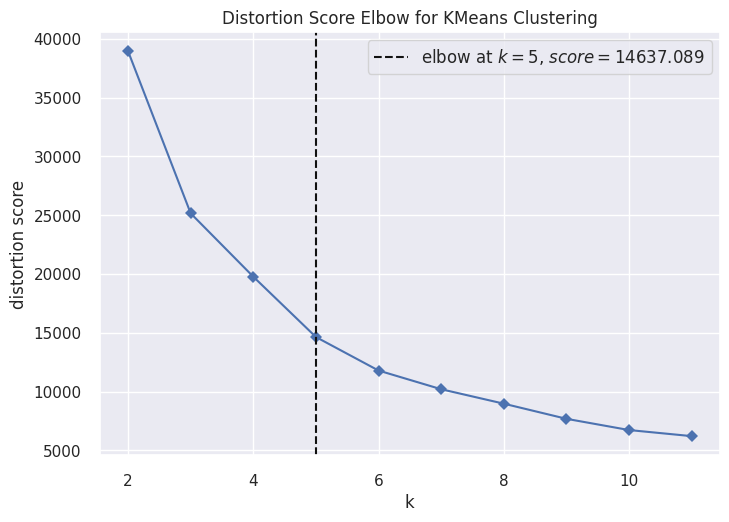

In [177]:
kmeans = KElbowVisualizer(c.KMeans(n_init='auto'),k=clusters, timings=False)
kmeans.fit(X)
kmeans.show();

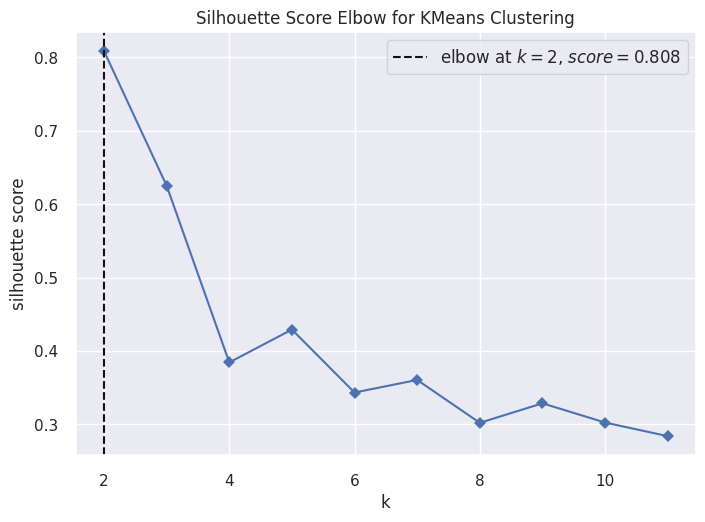

In [178]:
kmeans = KElbowVisualizer( c.KMeans(n_init='auto'), k=clusters, metric='silhouette', timings=False )
kmeans.fit( X )
kmeans.show();

## 7.2 Silhouette Analysis

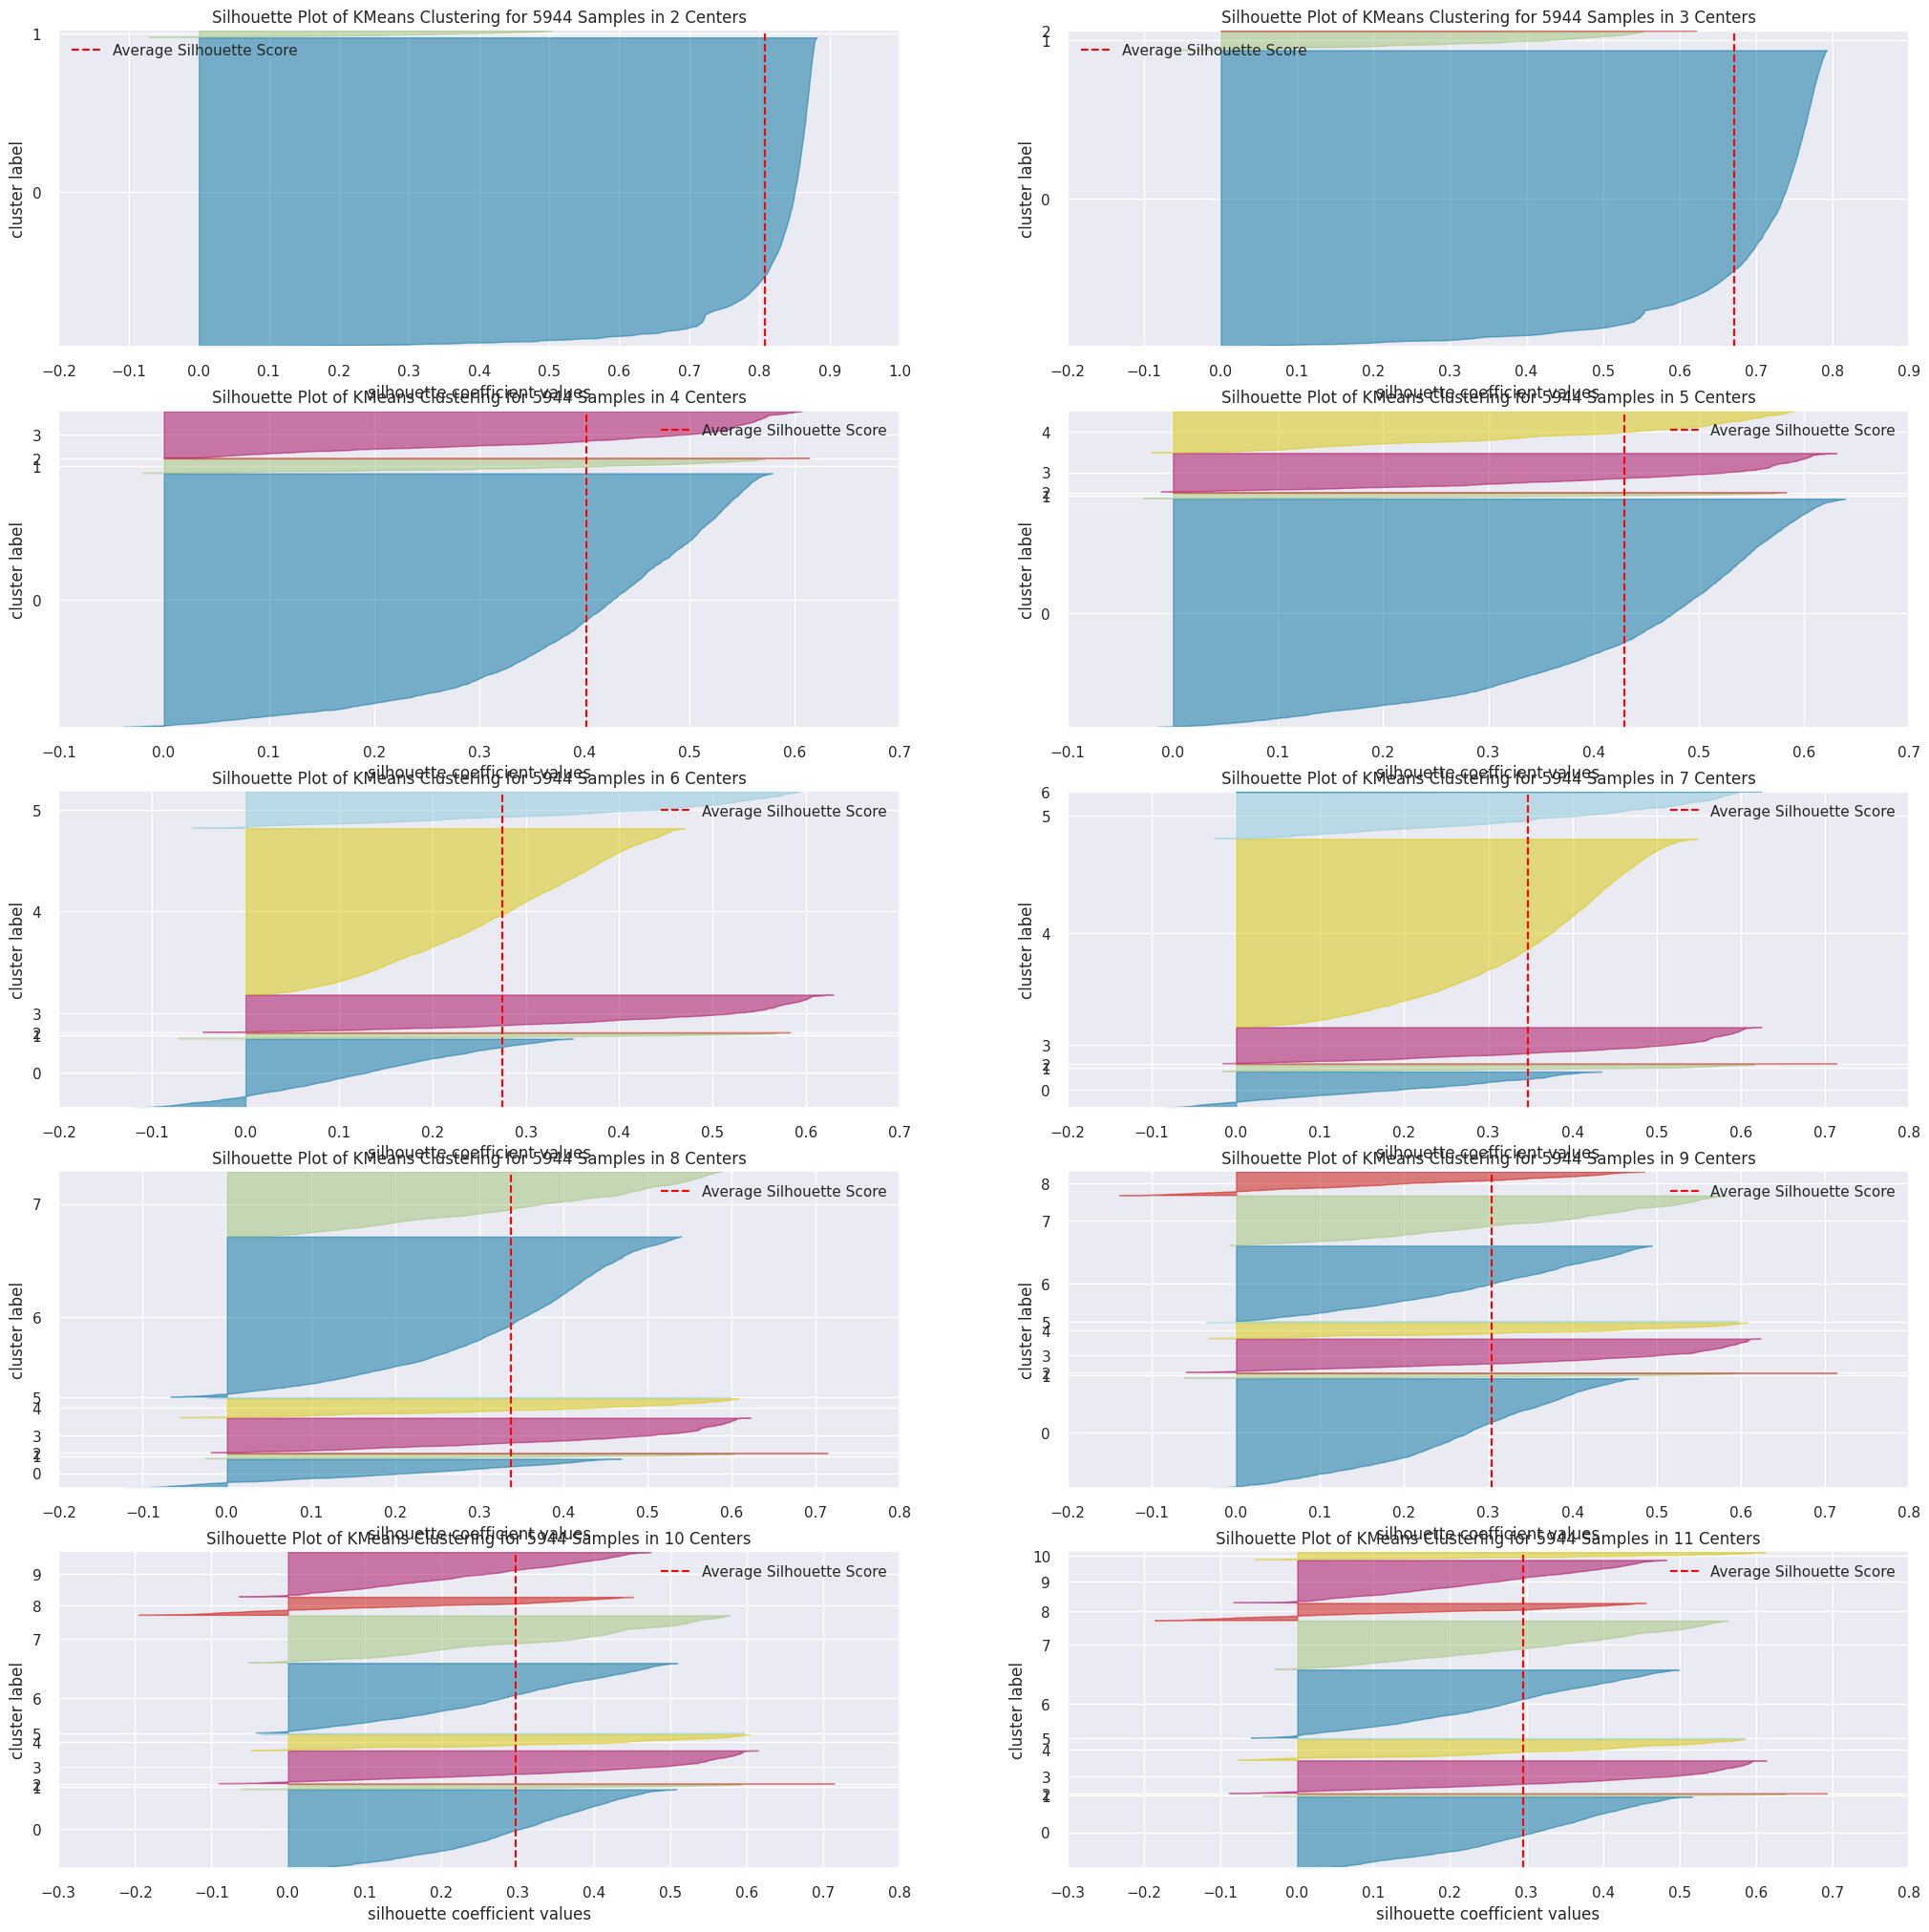

In [179]:
fig, ax = plt.subplots(5, 2, figsize=(25, 25))

for k in clusters:
    km = c.KMeans(n_clusters=k, n_init='auto',random_state=42)
    q, mod = divmod(k, 2)
    
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize()

#  8.0 Model training 

## 8.1 K-Means

In [180]:
# model definition
k = 10

kmeans = c.KMeans(n_clusters=k,random_state=42)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

## 8.2 Cluster validation

In [181]:
## WSS (Within-cluster sum of square)
print('WSS value: {}'.format(kmeans.inertia_))

## SS (Silhouette Score 
print('SS value: {}'.format(m.silhouette_score(X, labels, metric='euclidean')))

WSS value: 6681.661720440719
SS value: 0.3026974663943042


# 9.0 Cluster analysis

In [182]:
df9 = df6.copy()
df9['cluster'] = labels

df9['gross_revenue'] = ssgross.inverse_transform(df9[['gross_revenue']])
df9['recency_days'] = ssrecency.inverse_transform(df9[['recency_days']])
df9['total_invoices'] = ssinvoice.inverse_transform(df9[['total_invoices']])

## 9.1 Visualization inspection

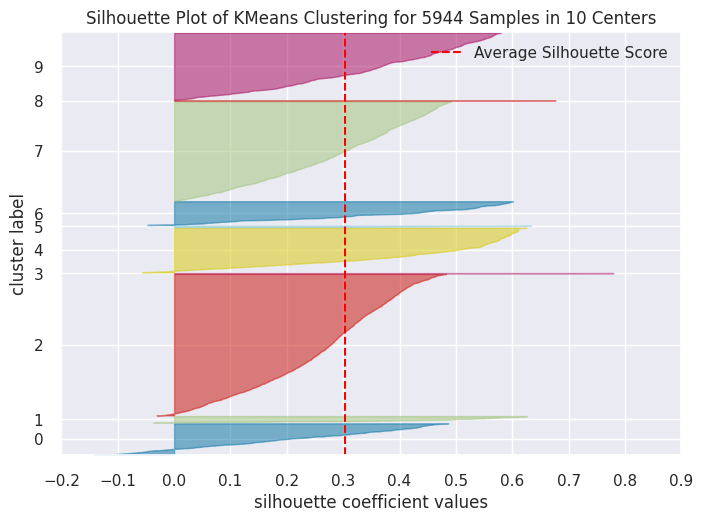

In [183]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

## 9.2 2d plot

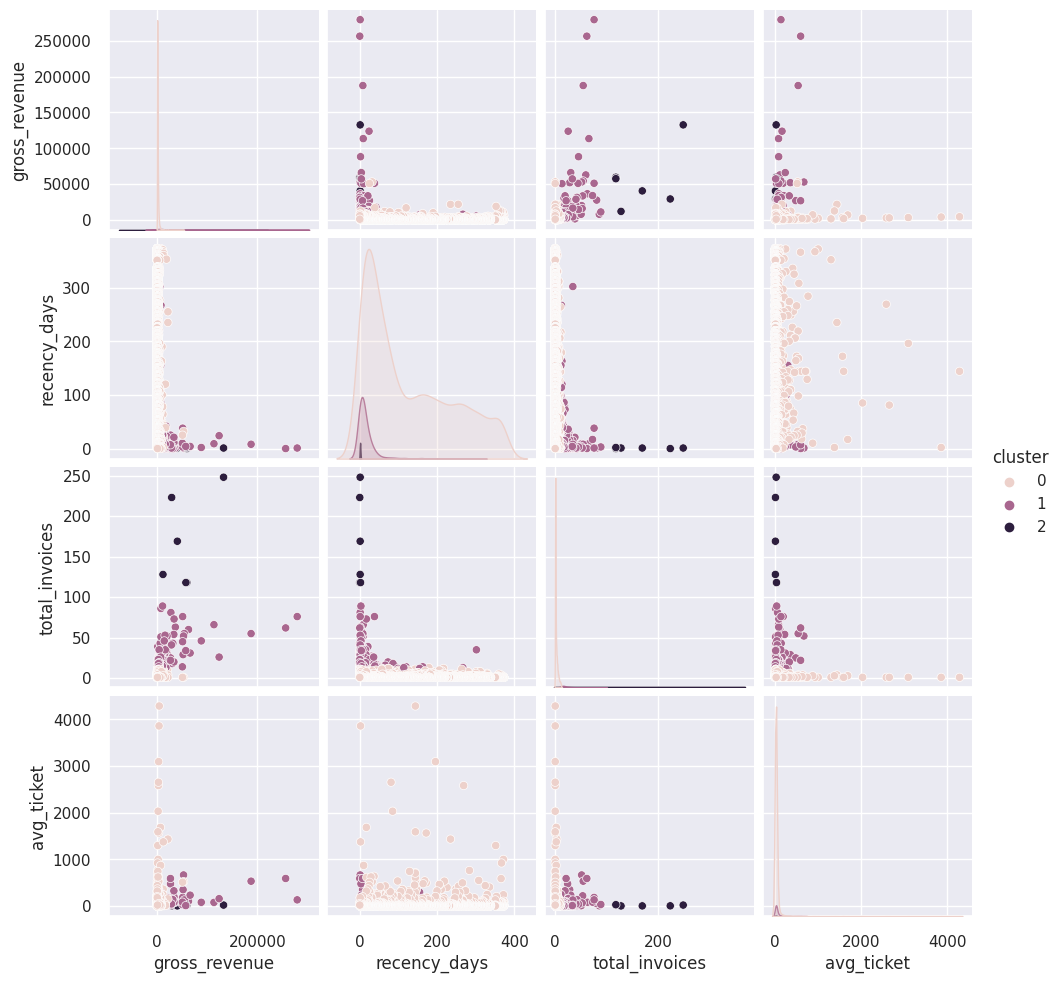

In [172]:
df_viz = df9.drop(columns='customer_id', axis=1)
sns.pairplot(df_viz, hue='cluster');

## 9.3 UMAP


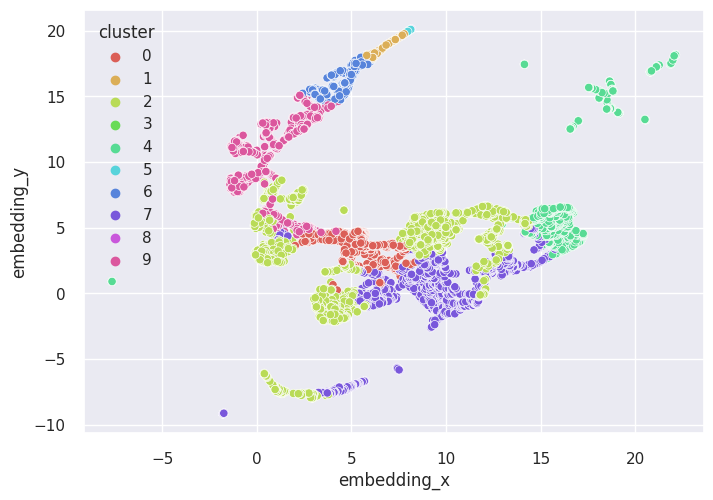

In [186]:
df_viz = df9.drop(columns='customer_id', axis=1)

reducer = umap.UMAP(n_neighbors=15, random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', 
                 hue='cluster', 
                 palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())),
                 data=df_viz);

## 9.4 Cluster profile

In [185]:
# Percentual of costumer
df_cluster = df9[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )
df_cluster['perc_customer']=df_cluster['perc_customer'].map('{:,.2f} %'.format)

# Avg Gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )
df_cluster=df_cluster.rename(columns={'gross_revenue':'avg_gross_revenue'})

# Gross revenue percentual
df_gross_perc = df9[['cluster', 'gross_revenue']].groupby('cluster').sum().reset_index()
df_cluster['gross_perc'] = 100*(df_cluster['avg_gross_revenue'] / df_cluster['avg_gross_revenue'].sum())
df_cluster['gross_perc']=df_cluster['gross_perc'].map('{:,.2f} %'.format)

# Avg recency days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how='inner', on='cluster')
df_cluster['recency_days']=df_cluster['recency_days'].map('{:,.2f}'.format)
df_cluster=df_cluster.rename(columns={'recency_days':'avg_recency_days'})

# Avg invoice_no
df_invoice_no = df9[['total_invoices', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_invoice_no, how='inner', on='cluster')
df_cluster['total_invoices']=df_cluster['total_invoices'].map('{:,.2f}'.format)
df_cluster=df_cluster.rename(columns={'total_invoices':'avg_invoices'})

df_cluster=df_cluster.sort_values(['avg_gross_revenue'],ascending=False).reset_index(drop=True)

df_cluster['avg_gross_revenue']=df_cluster['avg_gross_revenue'].map('$ {:,.2f}'.format)

df_cluster=df_cluster.rename(columns={'customer_id':'customers'})


df_cluster.loc[0:0,'cluster'] = 0
df_cluster.loc[1:1,'cluster'] = 1
df_cluster.loc[2:2,'cluster'] = 2

rows=df_cluster.shape[0:1]
rows=int(rows[0])

if rows>3:
        df_cluster.loc[3:3,'cluster'] = 3
        df_cluster.loc[4:4,'cluster'] = 4
        df_cluster.loc[5:5,'cluster'] = 5
        df_cluster.loc[6:6,'cluster'] = 6
        df_cluster.loc[7:7,'cluster'] = 7
        df_cluster.loc[8:8,'cluster'] = 8
        df_cluster.loc[9:9,'cluster'] = 9
        df_cluster.loc[10:10,'cluster'] = 10
else:
    None

df_cluster

,cluster,customer_id,perc_customer,avg_gross_revenue,gross_perc,avg_recency_days,avg_invoices
0,0,2,0.03 %,"$ 80,822.36",38.01 %,0.50,235.50
1,1,20,0.34 %,"$ 65,121.25",30.63 %,5.55,62.75
2,2,4,0.07 %,"$ 42,214.96",19.85 %,1.00,133.25
3,3,94,1.58 %,"$ 14,020.56",6.59 %,9.15,30.59
4,4,340,5.72 %,"$ 4,991.86",2.35 %,21.58,14.66
5,5,960,16.15 %,"$ 2,013.75",0.95 %,38.14,6.50
6,6,449,7.55 %,"$ 1,963.08",0.92 %,128.89,2.01
7,7,2022,34.02 %,$ 819.93,0.39 %,56.69,1.98
8,8,1416,23.82 %,$ 648.25,0.30 %,257.17,1.27
9,9,637,10.72 %,$ 8.65,0.00 %,189.33,1.07


# <font color='red'> 10.0. Deploy To Production </font>